In [1]:
"""Advent of Code - Day 22, Year 2023
Solution Started: Jan 11, 2025
Puzzle Link: https://adventofcode.com/2023/day/22
Solution by: abbasmoosajee07
Brief: [Tower of Bricks]
"""

#!/usr/bin/env python3

import os, re, copy, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
start_time = time.time()

# Load the input data from the specified file path
D22_file = "Day22_input.txt"
# D22_file_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), D22_file)

# Read and sort input data into a grid
with open(D22_file) as file:
    input_data = file.read().strip().split('\n')

def parse_input(input_list: list[str]) -> dict:
    graph = {}
    for brick_no, line in enumerate(input_list, start=1):
        result = []
        # Generate the brick name (Excel-like: A, B, ..., Z, AA, AB, ...)
        while brick_no > 0:
            brick_no -= 1  # Adjust to zero-indexed before modulus operation
            result.append(chr(brick_no % 26 + 65))  # Convert number to corresponding letter
            brick_no //= 26  # Move to the next place value

        brick_name = ''.join(result[::-1])  # Reverse the result to get the correct order

        # Parse the coordinates from the input string
        edge_1, edge_2 = line.split('~')
        edge_1_coords = tuple(map(int, edge_1.split(',')))
        edge_2_coords = tuple(map(int, edge_2.split(',')))
        # Store the brick name and the coordinates in the graph
        # print(brick_no, brick_name, edge_1_coords, edge_2_coords)
        graph[brick_name] = (edge_1_coords, edge_2_coords)

    return graph

def build_bricks(brick_edges: dict) -> dict:
    expanded_graph = {}
    for brick_name, (edge_1, edge_2) in brick_edges.items():
        # Unpack coordinates for clarity
        (x1, y1, z1), (x2, y2, z2) = edge_1, edge_2
        
        # Determine the ranges for each axis
        min_x, max_x = sorted([x1, x2])
        min_y, max_y = sorted([y1, y2])
        min_z, max_z = sorted([z1, z2])

        # Generate the set of all coordinates within the range
        brick_coords = {(dx, dy, dz) for dx in range(min_x, max_x + 1)
                                        for dy in range(min_y, max_y + 1)
                                        for dz in range(min_z, max_z + 1)}

        # Store the sorted list of coordinates
        expanded_graph[brick_name] = sorted(brick_coords)

    return expanded_graph

def find_dependent_bricks(brick_graph: dict) -> dict:
    dependencies = {}
    combo_checked = set()
    count = 0
    for name_1, brick_set_1 in brick_graph.items():
        dependencies[name_1] = []

        x1_coords = list(map(lambda x: x[0], brick_set_1))
        y1_coords = list(map(lambda x: x[1], brick_set_1))
        z1_coords = list(map(lambda x: x[2], brick_set_1))
        for name_2, brick_set_2 in brick_graph.items():
            combo = tuple(sorted((name_1, name_2)))
            if (name_1 != name_2) and (combo not in combo_checked):
                combo_checked.add(combo)
                x2_coords = list(map(lambda x: x[0], brick_set_2))
                y2_coords = list(map(lambda x: x[1], brick_set_2))
                z2_coords = list(map(lambda x: x[2], brick_set_2))
                count += 1

                # print(name_1, brick_set_1, '|', x1_coords, y1_coords, z1_coords)
                # print(name_2, brick_set_2, '|', x2_coords, y2_coords, z2_coords)
                # print()
    # print(count)
    return dependencies

test_input = ['1,0,1~1,2,1', '0,0,2~2,0,2', '0,2,3~2,2,3', '0,0,4~0,2,4', '2,0,5~2,2,5', '0,1,6~2,1,6', '1,1,8~1,1,9']

brick_graph = parse_input(test_input)
expanded_bricks = build_bricks(brick_graph)
dependent_graph = find_dependent_bricks(expanded_bricks)


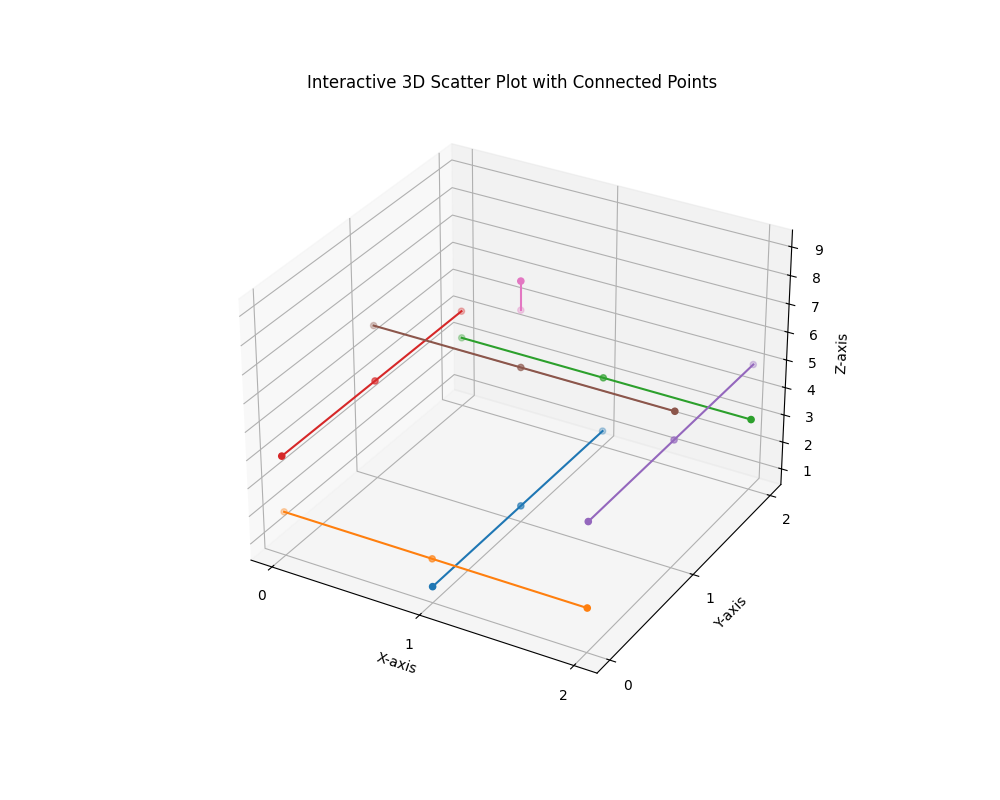

Execution Time = 0.32305


In [2]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Enable interactive plots in Jupyter Notebook
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with unique color and label
colors = plt.cm.tab10(range(len(expanded_bricks)))  # Use a colormap for unique colors
for i, (name, points) in enumerate(expanded_bricks.items()):
    xs, ys, zs = zip(*points)  # Unpack x, y, z coordinates
    
    # Scatter plot for points
    ax.scatter(xs, ys, zs, label=name, color=colors[i])
    
    # Line plot to connect points
    ax.plot(xs, ys, zs, color=colors[i], alpha=1)

# Set integer-only ticks
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))

# Labels and legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Interactive 3D Scatter Plot with Connected Points')
# ax.legend(title='Groups')

# Enable interactive mode
plt.ion()
plt.show()

print(f"Execution Time = {time.time() - start_time:.5f}")

# Brick A is the only brick supporting bricks B and C.
# Brick B is one of two bricks supporting brick D and brick E.
# Brick C is the other brick supporting brick D and brick E.
# Brick D supports brick F.
# Brick E also supports brick F.
# Brick F supports brick G.
# Brick G isn't supporting any bricks.